# Firm Name Matching v1.1
**Author:** Abhishek Bhave  
**Date:** December 2024  
**Purpose:** Match company names between Crunchbase and Pitchbook datasets

---

## Overview

This notebook matches firms from **Crunchbase** (~50K companies) to **Pitchbook** (~20K companies) using fuzzy name matching. It is designed to:

1. **Handle large datasets** through chunked processing
2. **Resume from interruptions** - stop anytime, resume later without losing progress
3. **Measure accuracy** on the full dataset for validation
4. **Be well-documented** for future team members

## Approach

1. **Preprocessing**: Clean company names (remove special characters, normalize whitespace)
2. **TF-IDF Indexing**: The `name_matching` library creates an index for fast candidate retrieval
3. **Fuzzy Matching**: Apply multiple distance metrics to score candidate pairs:
   - `discounted_levenshtein`: Character-level edits with position weighting
   - `SSK`: String Subsequence Kernel for partial/substring matches
   - `fuzzy_wuzzy_token_sort`: Handles word reordering ("Google Inc" vs "Inc Google")
4. **Chunked Processing**: Process Pitchbook data in batches to manage memory and allow resumption
5. **Filtering**: Keep high-confidence matches (score > threshold)
6. **Validation**: Analyze score distribution and state agreement rate

## Expected Runtime

| Stage | Time Estimate |
|-------|---------------|
| Load Crunchbase master data | 5-10 minutes |
| Per chunk (2000 rows) | 5-15 minutes |
| Full dataset (20K rows, 10 chunks) | 2-4 hours total |

**Note:** You can stop and resume at any time. Progress is saved after each chunk.


---
## 1. Configuration

All configurable parameters are defined here. Modify these values to adjust the matching behavior.


In [1]:
# ============================================================================
# CONFIGURATION - Modify these parameters as needed
# ============================================================================

# --- File Paths ---
CRUNCHBASE_FILE = "samplecrunchbase3.csv"   # Master data (to match against)
PITCHBOOK_FILE = "samplepitchbook3.csv"     # Data to be matched

# --- Column Names ---
CB_NAME_COL = "co1"          # Crunchbase company name column
PB_NAME_COL = "co2"          # Pitchbook company name column
CB_ID_COL = "uuid"           # Crunchbase unique identifier
PB_ID_COL = "idp"            # Pitchbook unique identifier

# --- Matching Parameters ---
TOP_N_CANDIDATES = 10        # Number of candidates to consider per name
SCORE_THRESHOLD = 80         # Minimum score for high-confidence matches

# --- Chunking Parameters ---
CHUNK_SIZE = 2000            # Number of Pitchbook rows per chunk
OUTPUT_DIR = "matching_results"  # Directory for intermediate chunk files
RESUME_ENABLED = True        # If True, skip already-completed chunks

# --- Output Files ---
OUTPUT_ALL_MATCHES = "firm_matches_all.csv"
OUTPUT_HIGH_CONFIDENCE = "firm_matches_high_confidence.csv"

print("Configuration loaded successfully!")
print(f"  - Chunk size: {CHUNK_SIZE}")
print(f"  - Score threshold: {SCORE_THRESHOLD}")
print(f"  - Resume enabled: {RESUME_ENABLED}")


Configuration loaded successfully!
  - Chunk size: 2000
  - Score threshold: 80
  - Resume enabled: True


---
## 2. Library Imports

Import all required libraries:
- `pandas`: Data manipulation and CSV handling
- `re`: Regular expressions for text preprocessing
- `os`: File system operations for resumable chunking
- `name_matching`: Core fuzzy matching library
- `tqdm`: Progress bars for long-running operations


In [2]:
# Standard library imports
import os
import re
from datetime import datetime

# Data manipulation
import pandas as pd

# Progress tracking
from tqdm import tqdm

# Name matching library
from name_matching.name_matcher import NameMatcher

# Display settings for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")


All libraries imported successfully!
Pandas version: 2.3.3


---
## 3. Data Loading

Load both datasets and display summary statistics.

**Data Sources:**
- **Crunchbase** (~50K companies): Master data that we match against
- **Pitchbook** (~20K companies): Data we want to find matches for


In [3]:
# Load Crunchbase data (master/reference dataset)
print("Loading Crunchbase data...")
df_cb = pd.read_csv(CRUNCHBASE_FILE)
print(f"  Loaded {len(df_cb):,} Crunchbase companies")
print(f"  Columns: {list(df_cb.columns)}")

# Load Pitchbook data (data to be matched)
print("\nLoading Pitchbook data...")
df_pb = pd.read_csv(PITCHBOOK_FILE)
print(f"  Loaded {len(df_pb):,} Pitchbook companies")
print(f"  Columns: {list(df_pb.columns)}")

# Calculate expected chunks
n_chunks = (len(df_pb) + CHUNK_SIZE - 1) // CHUNK_SIZE
print(f"\n  Will process in {n_chunks} chunks of {CHUNK_SIZE} rows each")


Loading Crunchbase data...
  Loaded 448,143 Crunchbase companies
  Columns: ['uuid', 'co1', 'descriotion1', 'state1', 'legalname1']

Loading Pitchbook data...
  Loaded 86,574 Pitchbook companies
  Columns: ['idp', 'co2', 'description2', 'state2']

  Will process in 44 chunks of 2000 rows each


In [4]:
# Preview Crunchbase data
print("=== Crunchbase Sample ===")
display(df_cb.head(5))


=== Crunchbase Sample ===


,uuid,co1,descriotion1,state1,legalname1
0,4a5428f6-2690-044c-6f75-5294198ba9e2,Arctic Heat Technologies,Manufacturer of carbon fiber heat tape for snow and ice melting,ak,NaN
1,1533bb46-e96c-47de-956c-50c8f2423217,Elite Real Estate Group,Elite Real Estate Group is a real estate agency that sells and buys residential and commercial p...,ak,Elite Real Estate Group
2,06ee124f-690f-42d6-9784-220f6d8d2ecc,Montis,"Montis Corporation provides accurate weather data by installing hardware at airports, ski resort...",ak,Montis Corporation
3,03c14730-bb3c-4f2d-b954-e1a4a0186376,Arctic Network Solutions,Arctic Network Solutions provides IT consulting and managed services.,ak,Arctic Network Solutions
4,b0f5ba90-5d17-4279-acdc-7b955ad68c52,SafeLogic,SafeLogic is a consulting organization that assists businesses of all sizes in meeting their saf...,ak,NaN


In [5]:
# Preview Pitchbook data
print("=== Pitchbook Sample ===")
display(df_pb.head(5))


=== Pitchbook Sample ===


,idp,co2,description2,state2
0,186819-49,blox (construction and engineering),developer of medical modules and prefabricated building components designed to offer optimized a...,al
1,436302-55,nrtc automation,provider of industrial automation services intended to provide decommissioning of manufacturing ...,al
2,434818-45,hdata,developer of a data analysis platform intended to help regulatory teams to manage and understand...,al
3,343713-52,ai metrics,developer of imaging software designed to assist radiologists in measuring and reporting cancer ...,al
4,399473-11,landing,operator of an accommodation marketplace intended to offer access to the global network of fully...,al


---
## 4. Preprocessing Functions

Company names need to be normalized before matching to handle:
- Special characters ("perplexity.ai" → "perplexity ai")
- Extra whitespace ("  Google   Inc  " → "Google Inc")
- Missing values (NaN → empty string)

**Note:** The `name_matching` library handles additional normalization:
- Lowercase conversion
- Legal suffix removal (Inc, LLC, Corp, etc.)
- Common word removal


In [6]:
def preprocess_company_name(text):
    """
    Preprocess company names for matching.
    
    Steps:
    1. Handle missing values (NaN → empty string)
    2. Replace non-alphanumeric characters with spaces
    3. Collapse multiple spaces into one
    4. Strip leading/trailing whitespace
    
    Args:
        text: Company name (string or NaN)
        
    Returns:
        Cleaned company name string
        
    Examples:
        "perplexity.ai" → "perplexity ai"
        "facebook, inc." → "facebook inc"
        "  Google   Inc  " → "Google Inc"
        None → ""
    """
    if pd.isna(text):
        return ""
    
    # Convert to string (in case of numeric values)
    text = str(text)
    
    # Replace non-letters/numbers with space
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    
    # Collapse multiple spaces into one and strip
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


# Test the preprocessing function
print("=== Preprocessing Examples ===")
test_names = [
    "perplexity.ai",
    "facebook, inc.",
    "X.com",
    "  Google   Inc  ",
    "Anthropic (AI Company)",
    None
]

for name in test_names:
    cleaned = preprocess_company_name(name)
    print(f"  '{name}' → '{cleaned}'")


=== Preprocessing Examples ===
  'perplexity.ai' → 'perplexity ai'
  'facebook, inc.' → 'facebook inc'
  'X.com' → 'X com'
  '  Google   Inc  ' → 'Google Inc'
  'Anthropic (AI Company)' → 'Anthropic AI Company'
  'None' → ''


---
## 5. Apply Preprocessing

Create cleaned name columns for both datasets.


In [7]:
# Apply preprocessing to Crunchbase
print("Preprocessing Crunchbase names...")
df_cb["co1_clean"] = df_cb[CB_NAME_COL].apply(preprocess_company_name)
print(f"  Done. Sample:")
display(df_cb[[CB_NAME_COL, "co1_clean"]].head(5))


Preprocessing Crunchbase names...
  Done. Sample:


,co1,co1_clean
0,Arctic Heat Technologies,Arctic Heat Technologies
1,Elite Real Estate Group,Elite Real Estate Group
2,Montis,Montis
3,Arctic Network Solutions,Arctic Network Solutions
4,SafeLogic,SafeLogic


In [8]:
# Apply preprocessing to Pitchbook
print("Preprocessing Pitchbook names...")
df_pb["co2_clean"] = df_pb[PB_NAME_COL].apply(preprocess_company_name)
print(f"  Done. Sample:")
display(df_pb[[PB_NAME_COL, "co2_clean"]].head(5))


Preprocessing Pitchbook names...
  Done. Sample:


,co2,co2_clean
0,blox (construction and engineering),blox construction and engineering
1,nrtc automation,nrtc automation
2,hdata,hdata
3,ai metrics,ai metrics
4,landing,landing


---
## 6. Initialize NameMatcher

Set up the name matching engine and load Crunchbase as the master data.

**Parameters explained:**
- `top_n`: Number of candidate matches to consider (higher = more thorough, slower)
- `lowercase`: Convert names to lowercase before matching
- `punctuations`: Remove punctuation (False = we handle this ourselves)
- `remove_ascii`: Remove non-ASCII characters (handles Unicode)
- `legal_suffixes`: Remove Inc, LLC, Corp, Ltd, etc.
- `common_words`: Remove common words like "The", "Company", "Group"

**Distance Metrics:**
- `discounted_levenshtein`: Edit distance with position weighting (edits at start penalized more)
- `SSK`: String Subsequence Kernel - measures shared subsequences
- `fuzzy_wuzzy_token_sort`: Tokenizes, sorts alphabetically, then compares

**Note:** Loading master data takes 5-10 minutes for ~50K records. This is done ONCE.


In [9]:
# Initialize the NameMatcher
print("Initializing NameMatcher...")
matcher = NameMatcher(
    top_n=TOP_N_CANDIDATES,
    lowercase=True,
    punctuations=False,       # We already preprocessed
    remove_ascii=True,
    legal_suffixes=True,      # Remove Inc, LLC, Corp, etc.
    common_words=True,        # Remove The, Company, Group, etc.
    verbose=True
)

# Set distance metrics
matcher.set_distance_metrics([
    'discounted_levenshtein',  # Character-level typos
    'SSK',                      # Substring matching
    'fuzzy_wuzzy_token_sort'    # Word reordering
])

print("NameMatcher initialized with 3 distance metrics.")


Initializing NameMatcher...
NameMatcher initialized with 3 distance metrics.


In [10]:
# Load Crunchbase as master data (THIS TAKES 5-10 MINUTES)
print("Loading master data (Crunchbase)...")
print(f"  Processing {len(df_cb):,} companies...")
print("  This may take 5-10 minutes. Please wait...")

start_time = datetime.now()

matcher.load_and_process_master_data(
    column='co1_clean',
    df_matching_data=df_cb,
    transform=True
)

elapsed = datetime.now() - start_time
print(f"\nMaster data loaded successfully!")
print(f"  Time elapsed: {elapsed}")


Loading master data (Crunchbase)...
  Processing 448,143 companies...
  This may take 5-10 minutes. Please wait...

Master data loaded successfully!
  Time elapsed: 0:00:06.201198


---
## 7. Resumable Chunked Matching Functions

These functions enable processing the full dataset in chunks with the ability to:
- **Stop anytime** - progress is saved after each chunk
- **Resume later** - re-run and it will skip completed chunks
- **Track progress** - see which chunks are done

**How it works:**
1. Split Pitchbook data into chunks of `CHUNK_SIZE` rows
2. For each chunk, check if output file already exists
3. If exists and `RESUME_ENABLED=True`, skip it
4. Otherwise, run matching and save results immediately
5. After all chunks complete, combine into final results


In [11]:
def get_completed_chunks(output_dir):
    """
    Check which chunks have already been processed.
    
    Args:
        output_dir: Directory containing chunk CSV files
        
    Returns:
        Set of completed chunk indices
    """
    if not os.path.exists(output_dir):
        return set()
    
    completed = set()
    for filename in os.listdir(output_dir):
        if filename.startswith("chunk_") and filename.endswith(".csv"):
            try:
                # Extract chunk number from filename (e.g., "chunk_0003.csv" → 3)
                chunk_num = int(filename.replace("chunk_", "").replace(".csv", ""))
                completed.add(chunk_num)
            except ValueError:
                continue
    
    return completed


def match_in_chunks(matcher, df_to_match, column, chunk_size, output_dir, resume=True):
    """
    Process matching in chunks with progress tracking and resume support.
    
    Args:
        matcher: Initialized NameMatcher with master data loaded
        df_to_match: DataFrame to find matches for (Pitchbook)
        column: Column name containing cleaned company names
        chunk_size: Number of rows per chunk
        output_dir: Directory to save intermediate results
        resume: If True, skip chunks that already have output files
        
    Returns:
        None (results saved to disk per chunk)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate total chunks
    total_rows = len(df_to_match)
    n_chunks = (total_rows + chunk_size - 1) // chunk_size
    
    print(f"=== Chunked Matching ===")
    print(f"  Total rows: {total_rows:,}")
    print(f"  Chunk size: {chunk_size:,}")
    print(f"  Total chunks: {n_chunks}")
    print(f"  Output directory: {output_dir}")
    
    # Check for existing progress
    completed_chunks = get_completed_chunks(output_dir) if resume else set()
    if completed_chunks:
        print(f"\n  Found {len(completed_chunks)} completed chunks. Resuming...")
        print(f"  Completed: {sorted(completed_chunks)}")
    
    # Process each chunk
    for i in tqdm(range(n_chunks), desc="Processing chunks"):
        # Skip already completed chunks
        if i in completed_chunks:
            continue
        
        # Calculate row indices for this chunk
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, total_rows)
        
        # Extract chunk
        chunk_df = df_to_match.iloc[start_idx:end_idx].copy().reset_index(drop=True)
        
        # Run matching on this chunk
        chunk_result = matcher.match_names(
            to_be_matched=chunk_df,
            column_matching=column
        )
        
        # Add original index to track back to full dataset
        chunk_result['original_idx'] = range(start_idx, end_idx)
        
        # Save immediately (enables resume)
        output_path = os.path.join(output_dir, f"chunk_{i:04d}.csv")
        chunk_result.to_csv(output_path, index=False)
    
    print(f"\nAll {n_chunks} chunks complete!")
    print(f"Results saved to: {output_dir}/")


def combine_chunk_results(output_dir):
    """
    Load and combine all chunk CSV files into a single DataFrame.
    
    Args:
        output_dir: Directory containing chunk CSV files
        
    Returns:
        Combined DataFrame with all matching results
    """
    # Get all chunk files, sorted by chunk number
    chunk_files = sorted([
        f for f in os.listdir(output_dir) 
        if f.startswith("chunk_") and f.endswith(".csv")
    ])
    
    if not chunk_files:
        raise ValueError(f"No chunk files found in {output_dir}")
    
    print(f"Combining {len(chunk_files)} chunk files...")
    
    # Load and concatenate all chunks
    dfs = []
    for filename in tqdm(chunk_files, desc="Loading chunks"):
        filepath = os.path.join(output_dir, filename)
        dfs.append(pd.read_csv(filepath))
    
    combined = pd.concat(dfs, ignore_index=True)
    
    # Sort by original index to maintain order
    combined = combined.sort_values('original_idx').reset_index(drop=True)
    
    print(f"Combined {len(combined):,} total matches.")
    return combined


print("Chunking functions defined successfully!")


Chunking functions defined successfully!


---
## 8. Run Full Dataset Matching

This is the main matching step. It will:
1. Process all Pitchbook companies in chunks
2. Save results after each chunk (enables resumption)
3. Skip any chunks that were already completed

**Estimated time:** 2-4 hours for the full dataset

**To stop and resume:**
- Interrupt the kernel at any time (Kernel → Interrupt)
- Re-run this cell later to continue from where you left off


In [14]:
# Check current progress before starting
completed = get_completed_chunks(OUTPUT_DIR)
n_chunks = (len(df_pb) + CHUNK_SIZE - 1) // CHUNK_SIZE

print(f"=== Progress Check ===")
print(f"  Total chunks needed: {n_chunks}")
print(f"  Chunks completed: {len(completed)}")
print(f"  Chunks remaining: {n_chunks - len(completed)}")

if len(completed) == n_chunks:
    print("\n  All chunks already complete! Proceed to combining results.")
else:
    print(f"\n  Ready to process {n_chunks - len(completed)} chunks.")


=== Progress Check ===
  Total chunks needed: 44
  Chunks completed: 2
  Chunks remaining: 42

  Ready to process 42 chunks.


In [15]:
# RUN THE MATCHING (this is the main processing step)
# 
# NOTE: This may take several hours for the full dataset.
# You can interrupt at any time and re-run to resume.

print(f"Starting matching at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

match_in_chunks(
    matcher=matcher,
    df_to_match=df_pb,
    column='co2_clean',
    chunk_size=CHUNK_SIZE,
    output_dir=OUTPUT_DIR,
    resume=RESUME_ENABLED
)

print("="*60)
print(f"Finished at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Starting matching at 2025-12-11 14:03:54
=== Chunked Matching ===
  Total rows: 86,574
  Chunk size: 2,000
  Total chunks: 44
  Output directory: matching_results

  Found 2 completed chunks. Resuming...
  Completed: [0, 1]


Processing chunks:   0%|          | 0/44 [00:00<?, ?it/s]

preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:   0%|          | 0/44 [00:07<?, ?it/s]

possible matches found   
 fuzzy matching...



Processing chunks:   7%|▋         | 3/44 [00:25<05:45,  8.43s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:   7%|▋         | 3/44 [00:32<05:45,  8.43s/it]

possible matches found   
 fuzzy matching...



Processing chunks:   9%|▉         | 4/44 [00:51<09:21, 14.05s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:   9%|▉         | 4/44 [00:58<09:21, 14.05s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  11%|█▏        | 5/44 [01:16<11:31, 17.74s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  11%|█▏        | 5/44 [01:24<11:31, 17.74s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  14%|█▎        | 6/44 [01:42<12:48, 20.22s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  14%|█▎        | 6/44 [01:49<12:48, 20.22s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  16%|█▌        | 7/44 [02:08<13:30, 21.91s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  16%|█▌        | 7/44 [02:16<13:30, 21.91s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  18%|█▊        | 8/44 [02:34<13:56, 23.23s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  18%|█▊        | 8/44 [02:42<13:56, 23.23s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  20%|██        | 9/44 [03:00<14:04, 24.12s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  20%|██        | 9/44 [03:07<14:04, 24.12s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  23%|██▎       | 10/44 [03:25<13:48, 24.37s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  23%|██▎       | 10/44 [03:32<13:48, 24.37s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  25%|██▌       | 11/44 [03:50<13:29, 24.52s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  25%|██▌       | 11/44 [03:56<13:29, 24.52s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  27%|██▋       | 12/44 [04:14<13:00, 24.40s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  27%|██▋       | 12/44 [04:21<13:00, 24.40s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  30%|██▉       | 13/44 [04:39<12:37, 24.44s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  30%|██▉       | 13/44 [04:45<12:37, 24.44s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  32%|███▏      | 14/44 [05:03<12:12, 24.42s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  32%|███▏      | 14/44 [05:10<12:12, 24.42s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  34%|███▍      | 15/44 [05:28<11:53, 24.61s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  34%|███▍      | 15/44 [05:35<11:53, 24.61s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  36%|███▋      | 16/44 [05:52<11:24, 24.46s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  36%|███▋      | 16/44 [05:58<11:24, 24.46s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  39%|███▊      | 17/44 [06:16<10:56, 24.32s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  39%|███▊      | 17/44 [06:23<10:56, 24.32s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  41%|████      | 18/44 [06:42<10:39, 24.61s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  41%|████      | 18/44 [06:49<10:39, 24.61s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  43%|████▎     | 19/44 [07:07<10:19, 24.80s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  43%|████▎     | 19/44 [07:15<10:19, 24.80s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  45%|████▌     | 20/44 [07:33<10:03, 25.16s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  45%|████▌     | 20/44 [07:40<10:03, 25.16s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  48%|████▊     | 21/44 [07:58<09:41, 25.29s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  48%|████▊     | 21/44 [08:06<09:41, 25.29s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  50%|█████     | 22/44 [08:24<09:21, 25.51s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  50%|█████     | 22/44 [08:32<09:21, 25.51s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  52%|█████▏    | 23/44 [08:50<08:57, 25.58s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  52%|█████▏    | 23/44 [08:58<08:57, 25.58s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  55%|█████▍    | 24/44 [09:16<08:30, 25.55s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  55%|█████▍    | 24/44 [09:23<08:30, 25.55s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  57%|█████▋    | 25/44 [09:41<08:02, 25.40s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  57%|█████▋    | 25/44 [09:48<08:02, 25.40s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  59%|█████▉    | 26/44 [10:06<07:35, 25.30s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  59%|█████▉    | 26/44 [10:13<07:35, 25.30s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  61%|██████▏   | 27/44 [10:32<07:12, 25.46s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  61%|██████▏   | 27/44 [10:39<07:12, 25.46s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  64%|██████▎   | 28/44 [10:57<06:46, 25.42s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  64%|██████▎   | 28/44 [11:04<06:46, 25.42s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  66%|██████▌   | 29/44 [11:22<06:21, 25.41s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  66%|██████▌   | 29/44 [11:29<06:21, 25.41s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  68%|██████▊   | 30/44 [11:47<05:55, 25.36s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  68%|██████▊   | 30/44 [11:54<05:55, 25.36s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  70%|███████   | 31/44 [12:13<05:29, 25.33s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  70%|███████   | 31/44 [12:20<05:29, 25.33s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  73%|███████▎  | 32/44 [12:38<05:03, 25.29s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  73%|███████▎  | 32/44 [12:45<05:03, 25.29s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  75%|███████▌  | 33/44 [13:04<04:39, 25.40s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  75%|███████▌  | 33/44 [13:11<04:39, 25.40s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  77%|███████▋  | 34/44 [13:30<04:17, 25.73s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  77%|███████▋  | 34/44 [13:38<04:17, 25.73s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  80%|███████▉  | 35/44 [13:56<03:52, 25.85s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  80%|███████▉  | 35/44 [14:04<03:52, 25.85s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  82%|████████▏ | 36/44 [14:23<03:28, 26.04s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  82%|████████▏ | 36/44 [14:31<03:28, 26.04s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  84%|████████▍ | 37/44 [14:49<03:03, 26.24s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  84%|████████▍ | 37/44 [14:57<03:03, 26.24s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  86%|████████▋ | 38/44 [15:16<02:38, 26.35s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  86%|████████▋ | 38/44 [15:24<02:38, 26.35s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  89%|████████▊ | 39/44 [15:43<02:12, 26.44s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  89%|████████▊ | 39/44 [15:50<02:12, 26.44s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  91%|█████████ | 40/44 [16:08<01:44, 26.23s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  91%|█████████ | 40/44 [16:16<01:44, 26.23s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  93%|█████████▎| 41/44 [16:35<01:18, 26.20s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  93%|█████████▎| 41/44 [16:42<01:18, 26.20s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  95%|█████████▌| 42/44 [17:00<00:52, 26.03s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  95%|█████████▌| 42/44 [17:07<00:52, 26.03s/it]

possible matches found   
 fuzzy matching...



Processing chunks:  98%|█████████▊| 43/44 [17:26<00:25, 25.90s/it]

done
preprocessing...

preprocessing complete 
 searching for matches...



Processing chunks:  98%|█████████▊| 43/44 [17:28<00:25, 25.90s/it]

possible matches found   
 fuzzy matching...



Processing chunks: 100%|██████████| 44/44 [17:33<00:00, 23.95s/it]

done

All 44 chunks complete!
Results saved to: matching_results/
Finished at 2025-12-11 14:21:28


---
## 9. Combine Chunk Results

After all chunks are complete, combine them into a single DataFrame.


In [16]:
# Combine all chunk results
matches = combine_chunk_results(OUTPUT_DIR)

print("\n=== Match Results Sample ===")
display(matches.head(10))


Combining 44 chunk files...


Loading chunks: 100%|██████████| 44/44 [00:00<00:00, 588.64it/s]

Combined 86,574 total matches.

=== Match Results Sample ===


,original_name,match_name,score,match_index,original_idx
0,blox construction and engineering,engine,0.000000,356306,0
1,nrtc automation,nrtc automation,100.000000,488,1
2,hdata,hdata,100.000000,1564,2
3,ai metrics,ai metrics,100.000000,463,3
4,landing,landing,100.000000,25697,4
5,coastal growers,coast,0.000000,155688,5
6,ranalia,rali,66.153539,176835,6
7,impact cooling,impact,0.000000,115589,7
8,nxtsoft,nxtsoft,100.000000,621,8
9,bama health foods,bama health foods,100.000000,1544,9


---
## 10. Merge with Original Data

Join the match results with the original Pitchbook and Crunchbase data to create a comprehensive output.


In [17]:
# Merge matches with Pitchbook data
print("Merging with Pitchbook data...")
combined = pd.merge(
    df_pb.reset_index(drop=True),
    matches,
    how='left',
    left_index=True,
    right_on='original_idx'
)

print(f"  Merged {len(combined):,} rows")


Merging with Pitchbook data...
  Merged 86,574 rows


In [18]:
# Add Crunchbase columns for matched companies
print("Adding Crunchbase data for matched companies...")

# Columns to bring from Crunchbase
cb_cols_to_add = ['uuid', 'co1', 'legalname1', 'state1']

for col in cb_cols_to_add:
    if col in df_cb.columns:
        combined[f'cb_{col}'] = combined['match_index'].apply(
            lambda idx: df_cb.iloc[int(idx)][col] if pd.notna(idx) and idx >= 0 else None
        )
        print(f"  Added cb_{col}")

print(f"\nCombined dataset shape: {combined.shape}")


Adding Crunchbase data for matched companies...
  Added cb_uuid
  Added cb_co1
  Added cb_legalname1
  Added cb_state1

Combined dataset shape: (86574, 14)


In [19]:
# Preview combined data
print("=== Combined Data Sample ===")
display(combined[['co2', 'cb_co1', 'score', 'state2', 'cb_state1']].head(15))


=== Combined Data Sample ===


,co2,cb_co1,score,state2,cb_state1
0,blox (construction and engineering),eNGINE,0.000000,al,pa
1,nrtc automation,NRTC Automation,100.000000,al,al
2,hdata,HData,100.000000,al,al
3,ai metrics,AI Metrics,100.000000,al,al
4,landing,Landing,100.000000,al,ca
5,coastal growers,Coast,0.000000,al,fl
6,ranalia,Rali,66.153539,al,ga
7,impact cooling,IMPACT,0.000000,al,co
8,nxtsoft,NXTsoft,100.000000,al,al
9,bama health foods,Bama Health Foods,100.000000,al,al


---
## 11. Accuracy Analysis

Analyze the quality of matches through:
1. **Score Distribution**: How confident are our matches?
2. **State Agreement**: Do matched companies have the same state? (validation metric)
3. **Sample Review**: Manual inspection of matches at various confidence levels


In [20]:
# Score Distribution
print("=== Match Score Distribution ===")
print(combined['score'].describe())

print("\n=== Score Buckets ===")
score_buckets = pd.cut(
    combined['score'],
    bins=[0, 50, 60, 70, 80, 90, 100],
    labels=['0-50', '50-60', '60-70', '70-80', '80-90', '90-100']
)
bucket_counts = score_buckets.value_counts().sort_index()
print(bucket_counts)
print(f"\nTotal: {bucket_counts.sum():,}")


=== Match Score Distribution ===
count    86574.000000
mean        82.455325
std         29.167121
min          0.000000
25%         70.146417
50%        100.000000
75%        100.000000
max        100.000000
Name: score, dtype: float64

=== Score Buckets ===
score
0-50       5829
50-60      4430
60-70      6116
70-80      5272
80-90      3652
90-100    56075
Name: count, dtype: int64

Total: 81,374


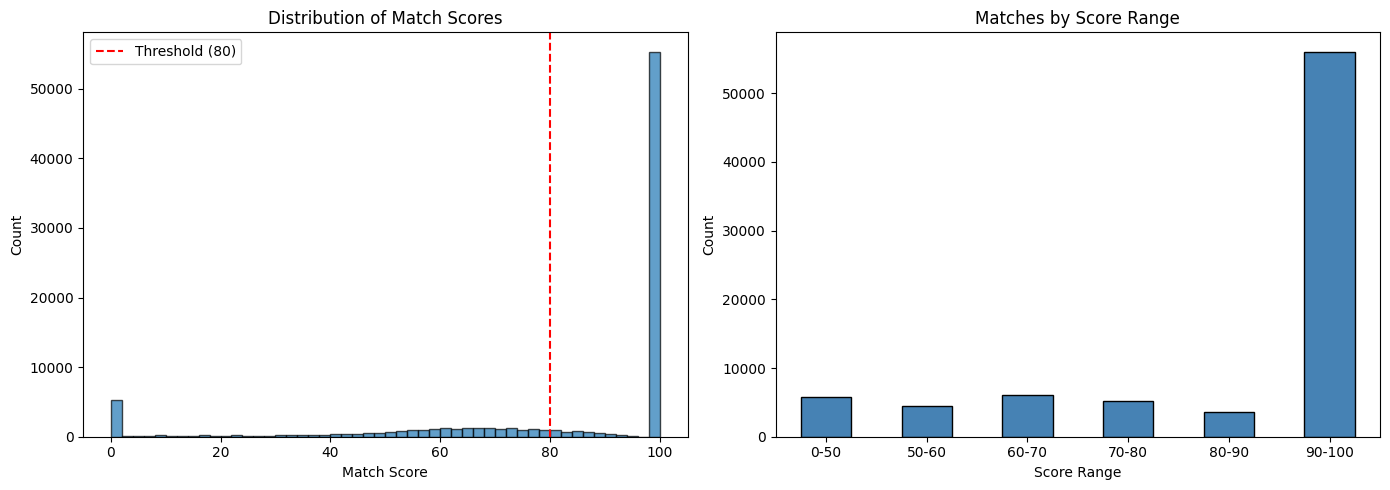

In [21]:
# Visualize score distribution (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(combined['score'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=SCORE_THRESHOLD, color='red', linestyle='--', 
                    label=f'Threshold ({SCORE_THRESHOLD})')
    axes[0].set_xlabel('Match Score')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Match Scores')
    axes[0].legend()
    
    # Bar chart of buckets
    bucket_counts.plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
    axes[1].set_xlabel('Score Range')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Matches by Score Range')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("(matplotlib not available for visualization)")


In [22]:
# State Agreement Analysis
# Same company should typically be registered in the same state
# High state agreement rate indicates good match quality

print("=== State Agreement Analysis ===")

# Create state comparison columns
combined['pb_state_norm'] = combined['state2'].str.lower().str.strip()
combined['cb_state_norm'] = combined['cb_state1'].str.lower().str.strip()
combined['state_match'] = combined['pb_state_norm'] == combined['cb_state_norm']

# Overall state agreement
valid_states = combined.dropna(subset=['pb_state_norm', 'cb_state_norm'])
overall_agreement = valid_states['state_match'].mean() * 100
print(f"Overall state agreement: {overall_agreement:.1f}% ({valid_states['state_match'].sum():,} / {len(valid_states):,})")

# State agreement by score bucket
print("\nState agreement by score range:")
for bucket_name, bucket_df in valid_states.groupby(score_buckets[valid_states.index]):
    agreement = bucket_df['state_match'].mean() * 100
    count = len(bucket_df)
    print(f"  {bucket_name}: {agreement:.1f}% ({count:,} matches)")


=== State Agreement Analysis ===
Overall state agreement: 58.2% (50,367 / 86,574)

State agreement by score range:
  0-50: 16.9% (5,829 matches)
  50-60: 22.2% (4,430 matches)
  60-70: 17.9% (6,116 matches)
  70-80: 16.6% (5,272 matches)
  80-90: 16.6% (3,652 matches)
  90-100: 80.5% (56,075 matches)


/var/folders/hh/ydg79r4d2357snpp2xyjqlc00000gn/T/ipykernel_30581/3326202764.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bucket_name, bucket_df in valid_states.groupby(score_buckets[valid_states.index]):


In [23]:
# Sample High-Confidence Matches (for manual review)
print(f"=== Sample High-Confidence Matches (score > {SCORE_THRESHOLD}) ===")
high_conf = combined[combined['score'] > SCORE_THRESHOLD].copy()
print(f"Total high-confidence matches: {len(high_conf):,}")
print(f"Match rate: {len(high_conf) / len(combined) * 100:.1f}%")

# Random sample for review
sample = high_conf.sample(min(20, len(high_conf)), random_state=42)
display(sample[['co2', 'cb_co1', 'score', 'state2', 'cb_state1']])


=== Sample High-Confidence Matches (score > 80) ===
Total high-confidence matches: 59,727
Match rate: 69.0%


,co2,cb_co1,score,state2,cb_state1
44623,big easy bucha,Big Easy Bucha,100.000000,la,la
61873,context matters,Context Matters,100.000000,ny,ny
64215,mediflix,Mediflix,100.000000,ny,ny
8969,farm(x),Farm'd,100.000000,ca,ga
76880,callidus,iCallidus,90.422818,tx,md
31497,kintow,Kinto,87.384287,de,fl
75401,hyco1,HYCO1,100.000000,tx,tx
53872,uncensored ai,Uncensored AI,100.000000,ne,ne
28169,savvy (other insurance),Savvy Otter,90.234895,ca,al
67683,owic technologies,OWiC Technologies,100.000000,nc,ny


In [24]:
# Sample Medium-Confidence Matches (for understanding edge cases)
print(f"=== Sample Medium-Confidence Matches (score 60-{SCORE_THRESHOLD}) ===")
medium_conf = combined[(combined['score'] >= 60) & (combined['score'] <= SCORE_THRESHOLD)].copy()
print(f"Total medium-confidence matches: {len(medium_conf):,}")

if len(medium_conf) > 0:
    sample = medium_conf.sample(min(15, len(medium_conf)), random_state=42)
    display(sample[['co2', 'cb_co1', 'score', 'state2', 'cb_state1']])


=== Sample Medium-Confidence Matches (score 60-80) ===
Total medium-confidence matches: 11,388


,co2,cb_co1,score,state2,cb_state1
29604,magenta ( business/productivity software),eProductivity Software,69.336132,co,pa
12448,confee,Confi,63.458151,ca,ma
11251,kibeam,Beam,69.836765,ca,ca
6510,hireglide,Glide,61.477685,ca,ca
79481,chubbies,Hubbe,68.932086,tx,ca
50160,avanti battery,Avanti & Avanti,67.006046,ma,fl
83239,novoloom,Novo,65.092916,wa,wa
62478,weatherman umbrella,Weatherman,67.889010,ny,ny
56602,proathlete,Athlete+,74.182063,ny,fl
68239,murphi.ai,Morphi,76.260024,nc,ny


In [25]:
# Sample Low-Confidence Matches (to understand failure modes)
print("=== Sample Low-Confidence Matches (score < 60) ===")
low_conf = combined[combined['score'] < 60].copy()
print(f"Total low-confidence matches: {len(low_conf):,}")

if len(low_conf) > 0:
    sample = low_conf.sample(min(10, len(low_conf)), random_state=42)
    display(sample[['co2', 'cb_co1', 'score', 'state2', 'cb_state1']])


=== Sample Low-Confidence Matches (score < 60) ===
Total low-confidence matches: 15,459


,co2,cb_co1,score,state2,cb_state1
690,life365.health,IM365 Health,53.391585,az,ca
72343,ultra capital,Capita,20.341316,pa,sc
66530,2way (information services (b2c)),Forma,6.514435,ny,ca
53557,cozumel tourbase,Zume,35.886958,mt,ca
1991,krush burger international,Krush,52.989428,ca,ca
18289,autoscience,Science,0.000000,ca,ca
21531,backrow studios,Studio,0.000000,ca,ny
59606,aimÃ© leon dore,Leon,39.307078,ny,ny
78315,umbrella (business/productivity software),Umbrella,51.434929,tx,tx
40160,playbuilders of hawai,Playbuilt,55.556428,hi,ca


In [26]:
# Exact match analysis
print("=== Exact Match Analysis ===")
combined['exact_match'] = combined['co2_clean'].str.lower() == combined['match_name'].str.lower()

exact_count = combined['exact_match'].sum()
print(f"Exact matches (after preprocessing): {exact_count:,}")
print(f"Exact match rate: {exact_count / len(combined) * 100:.1f}%")


=== Exact Match Analysis ===
Exact matches (after preprocessing): 49,600
Exact match rate: 57.3%


---
## 12. Filter & Export Results

Prepare final output files:
1. **All matches**: Every Pitchbook company with its best Crunchbase match
2. **High-confidence matches**: Only matches with score > threshold


In [27]:
# Prepare export dataset
print("Preparing export dataset...")

# Select columns for export (in logical order)
export_cols = [
    # Pitchbook identifiers
    'idp',
    'co2',
    'state2',
    
    # Crunchbase identifiers
    'cb_uuid',
    'cb_co1',
    'cb_legalname1',
    'cb_state1',
    
    # Match quality
    'score',
    'exact_match',
]

# Filter to columns that exist
export_cols = [c for c in export_cols if c in combined.columns]
export_df = combined[export_cols].copy()

# Rename for clarity
export_df = export_df.rename(columns={
    'idp': 'pitchbook_id',
    'co2': 'pitchbook_name',
    'state2': 'pitchbook_state',
    'cb_uuid': 'crunchbase_uuid',
    'cb_co1': 'crunchbase_name',
    'cb_legalname1': 'crunchbase_legal_name',
    'cb_state1': 'crunchbase_state',
    'score': 'match_score',
})

print(f"Export dataset prepared: {len(export_df):,} rows, {len(export_df.columns)} columns")
display(export_df.head(10))


Preparing export dataset...
Export dataset prepared: 86,574 rows, 9 columns


,pitchbook_id,pitchbook_name,pitchbook_state,crunchbase_uuid,crunchbase_name,crunchbase_legal_name,crunchbase_state,match_score,exact_match
0,186819-49,blox (construction and engineering),al,b13e13b7-9017-43df-a7e4-cd25bd478806,eNGINE,Engine LLC.,pa,0.000000,False
1,436302-55,nrtc automation,al,9c8419b2-4d4b-47d7-8101-b2aa915f30ae,NRTC Automation,"Nrtc Alabama, Inc.",al,100.000000,True
2,434818-45,hdata,al,b51601ee-fd18-4cc9-8015-179dd4174525,HData,"HData, Inc.",al,100.000000,True
3,343713-52,ai metrics,al,1c5958cb-c061-4765-a598-f9e85d715cd3,AI Metrics,"AI Metrics, Inc.",al,100.000000,True
4,399473-11,landing,al,54e9fec2-4029-4d14-bc44-eb5655cad5f8,Landing,"The Landing Home, Inc.",ca,100.000000,True
5,541351-81,coastal growers,al,682f4108-633c-4194-a5cb-b80f1deb5b88,Coast,"COAST Systems, LLC.",fl,0.000000,False
6,588590-56,ranalia,al,7c034ac2-e789-46ba-9e21-372e0797bce0,Rali,"Rali Solutions, LLC",ga,66.153539,False
7,539442-73,impact cooling,al,8452675e-f332-46c8-8d24-b9150ba31eda,IMPACT,IMPACT LLC,co,0.000000,False
8,264510-91,nxtsoft,al,28d5bf52-0a76-403a-8bf4-ebb7db472eec,NXTsoft,NXTsoft LLC,al,100.000000,True
9,546676-93,bama health foods,al,af9d8d1b-2897-4da6-9cee-4664e5b8e6d1,Bama Health Foods,"Bama Health Foods, LLC.",al,100.000000,True


In [28]:
# Export all matches
print(f"Saving all matches to: {OUTPUT_ALL_MATCHES}")
export_df.to_csv(OUTPUT_ALL_MATCHES, index=False)
print(f"  Saved {len(export_df):,} rows")

# Export high-confidence matches
high_conf_export = export_df[export_df['match_score'] > SCORE_THRESHOLD]
print(f"\nSaving high-confidence matches to: {OUTPUT_HIGH_CONFIDENCE}")
high_conf_export.to_csv(OUTPUT_HIGH_CONFIDENCE, index=False)
print(f"  Saved {len(high_conf_export):,} rows")


Saving all matches to: firm_matches_all.csv
  Saved 86,574 rows

Saving high-confidence matches to: firm_matches_high_confidence.csv
  Saved 59,727 rows


---
## 13. Summary Statistics

Final summary of the matching run.


In [29]:
# Final Summary
print("=" * 60)
print("MATCHING SUMMARY")
print("=" * 60)

print(f"\n--- Data ---")
print(f"Crunchbase companies (master): {len(df_cb):,}")
print(f"Pitchbook companies (matched): {len(df_pb):,}")

print(f"\n--- Configuration ---")
print(f"Chunk size: {CHUNK_SIZE}")
print(f"Score threshold: {SCORE_THRESHOLD}")
print(f"Top N candidates: {TOP_N_CANDIDATES}")

print(f"\n--- Results ---")
print(f"Total matches generated: {len(export_df):,}")
print(f"High-confidence matches (score > {SCORE_THRESHOLD}): {len(high_conf_export):,}")
print(f"High-confidence match rate: {len(high_conf_export) / len(export_df) * 100:.1f}%")

print(f"\n--- Quality Metrics ---")
print(f"Exact matches: {exact_count:,} ({exact_count / len(combined) * 100:.1f}%)")
print(f"State agreement (high-conf): {high_conf[high_conf['state_match']].shape[0]:,} / {high_conf.dropna(subset=['pb_state_norm', 'cb_state_norm']).shape[0]:,}")

print(f"\n--- Output Files ---")
print(f"All matches: {OUTPUT_ALL_MATCHES}")
print(f"High-confidence: {OUTPUT_HIGH_CONFIDENCE}")
print(f"Intermediate chunks: {OUTPUT_DIR}/")

print("\n" + "=" * 60)
print("COMPLETE")
print("=" * 60)


MATCHING SUMMARY

--- Data ---
Crunchbase companies (master): 448,143
Pitchbook companies (matched): 86,574

--- Configuration ---
Chunk size: 2000
Score threshold: 80
Top N candidates: 10

--- Results ---
Total matches generated: 86,574
High-confidence matches (score > 80): 59,727
High-confidence match rate: 69.0%

--- Quality Metrics ---
Exact matches: 49,600 (57.3%)
State agreement (high-conf): 45,744 / 59,727

--- Output Files ---
All matches: firm_matches_all.csv
High-confidence: firm_matches_high_confidence.csv
Intermediate chunks: matching_results/

COMPLETE


---
## Appendix: Utility Functions

Additional helper functions for common operations.


In [ ]:
def cleanup_chunks(output_dir, confirm=True):
    """
    Delete all chunk files to start fresh.
    
    Args:
        output_dir: Directory containing chunk files
        confirm: If True, ask for confirmation before deleting
    """
    if not os.path.exists(output_dir):
        print(f"Directory does not exist: {output_dir}")
        return
    
    chunk_files = [f for f in os.listdir(output_dir) 
                   if f.startswith("chunk_") and f.endswith(".csv")]
    
    if not chunk_files:
        print("No chunk files to delete.")
        return
    
    print(f"Found {len(chunk_files)} chunk files in {output_dir}")
    
    if confirm:
        response = input("Delete all chunk files? (yes/no): ")
        if response.lower() != 'yes':
            print("Cancelled.")
            return
    
    for f in chunk_files:
        os.remove(os.path.join(output_dir, f))
    
    print(f"Deleted {len(chunk_files)} chunk files.")


# Uncomment to use:
# cleanup_chunks(OUTPUT_DIR)


In [ ]:
def inspect_match(pitchbook_name, df_combined):
    """
    Look up matching details for a specific Pitchbook company.
    
    Args:
        pitchbook_name: Name of the Pitchbook company to look up
        df_combined: The combined DataFrame with match results
    """
    matches = df_combined[df_combined['co2'].str.contains(pitchbook_name, case=False, na=False)]
    
    if len(matches) == 0:
        print(f"No matches found for: {pitchbook_name}")
        return
    
    print(f"Found {len(matches)} matching Pitchbook companies:")
    display(matches[['co2', 'cb_co1', 'score', 'state2', 'cb_state1']])


# Example usage:
# inspect_match("google", combined)
